In [ ]:
!pip install regex
!pip install pyLDAvis==3.4.1
!pip install tdqm
!pip install wordninja

In [ ]:
#try 2.1.2 for pyLDAvis
# 2.0.0
# 1.5.1


In [ ]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('winter')

import re
from tqdm import tqdm


import collections
from collections import Counter

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler


import wordninja

import pyLDAvis
pyLDAvis.enable_notebook()

# !pip install detoxify
from detoxify import Detoxify
detox = Detoxify('unbiased')


In [5]:
#Read and convert csv files to data frames
before_war = pd.read_csv("before_war.csv")
war_and_after = pd.read_csv("war_and_afterwards.csv")


In [21]:
'''
This function removes stopwords, tokenizes the text, and performs other basic text processing. 
I used wordninja to split the hashtags up into separate words 
The cleaned text will be stored in another column called cleaned_text.
# '''

from tqdm import tqdm  # Import tqdm library

# Set up stopwords
stop_words = set(stopwords.words('english'))

#add space before 'putin' in hashtags
def preprocess_hashtags(text):
    text = text.replace("#putin", "#put in")
    return text

def break_hashtags(text):
    text = preprocess_hashtags(text)
    #split hashtag words
    words = wordninja.split(text)
    return words

#ensure "putin" does not get broken up
def fix_putin(words):
    for i, word in enumerate(words):
        if word == 'put' and i < len(words)-1 and words[i+1] == 'in':
            words[i] = 'putin'
            del words[i+1]
    return words

#Clean the text data
def clean_text(text):
    #Remove any links via re
    text = re.sub(r'http\S+', ' ', text)

    #only accept alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #split hashtags into separate words
    words = []
    for hashtag in text.split():
        broken_words = break_hashtags(hashtag)
        fixed_words = fix_putin(broken_words)
        words.extend(fixed_words)

    #Tokenize text and make everything lowercase
    tokens = word_tokenize(' '.join(words).lower())
    
    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

tqdm.pandas()

#Clean the 'text' column and save cleaned text as 'cleaned_text'
# before_war['cleaned_text'] = before_war.apply(clean_text, axis=1)
# war_and_after['cleaned_text'] = war_and_after.apply(clean_text, axis=1)
# Clean the 'text' column and save cleaned text as 'cleaned_text'
before_war['cleaned_text'] = before_war['text'].progress_apply(clean_text)
war_and_after['cleaned_text'] = war_and_after['text'].progress_apply(clean_text)

100%|█████████████████████████████| 8268526/8268526 [1:34:50<00:00, 1453.04it/s]


In [43]:
#make smaller datasets
#stratified random sampling for before_war dataset
before_war_sample = before_war.apply(lambda x: x.sample(frac=0.5, random_state=42))

# #stratified random sampling for war_and_after dataset
war_and_after_sample = war_and_after.apply(lambda x: x.sample(frac=0.2, random_state=42))



# Vectorize Text Data

In [ ]:
#before War 
before_war_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 5,
                                ngram_range=(2,4))

before_war_tfidf = before_war_vect.fit_transform(before_war_sample['cleaned_text'])
print(before_war_tfidf.shape)

#after war
war_and_after_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 5,
                                ngram_range=(2,4))

war_and_after_tfidf = war_and_after_vect.fit_transform(war_and_after_sample['cleaned_text'])
print(war_and_after_tfidf.shape)


/tmp/ipykernel_134475/2954331870.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)


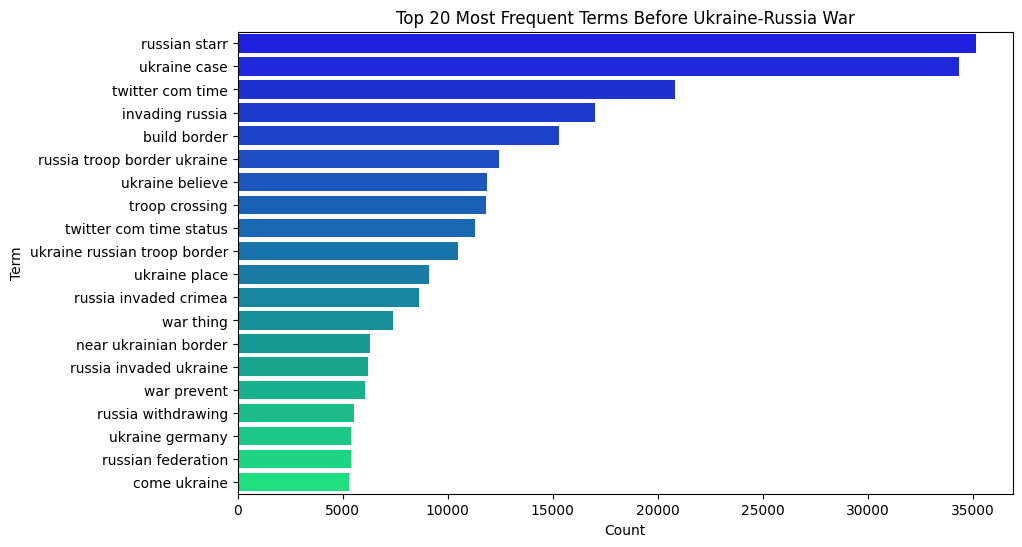

/tmp/ipykernel_134475/2954331870.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)


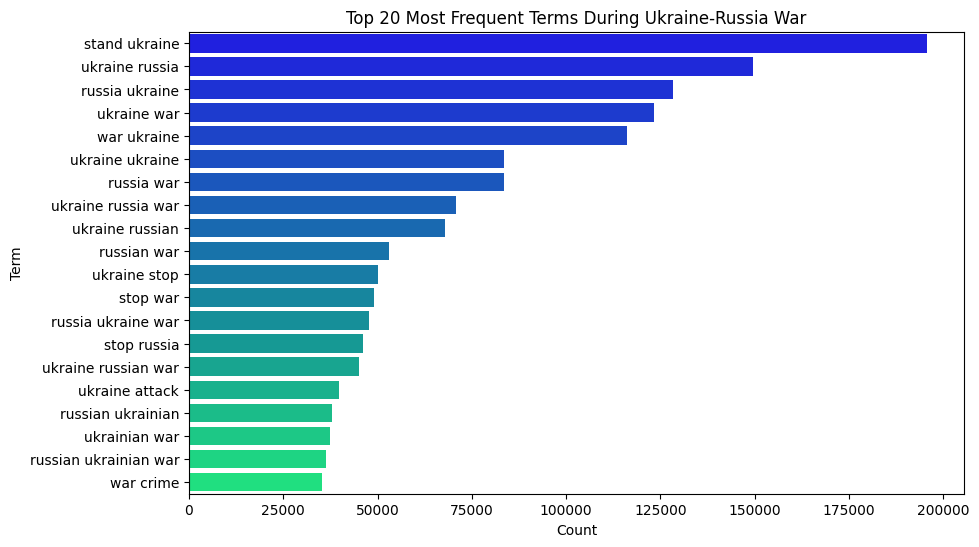

In [22]:
#Most frequent words in before_war
token_counts_before_war = np.array(before_war_tfidf.sum(axis=0))[0]
sorted_indices = np.argsort(token_counts_before_war)[::-1]
vocab_before_war = before_war_vect.get_feature_names_out()
term_freq_before_war = [(vocab_before_war[i], token_counts_before_war[i]) for i in sorted_indices]
most_frequent_df = pd.DataFrame(term_freq_before_war, columns=['Term', 'Count'])


plt.figure(figsize=(10, 6))
num_colors = most_frequent_df.head(20).shape[0]
palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, num_colors)])
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)
plt.title('Top 20 Most Frequent Terms Before Ukraine-Russia War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()

#Most frequent words in after_war
token_counts_war_and_after = np.array(war_and_after_tfidf.sum(axis=0))[0]
sorted_indices = np.argsort(token_counts_war_and_after)[::-1]
vocab_after_war= war_and_after_vect.get_feature_names_out()
term_freq_war_and_after = [(vocab_after_war[i], token_counts_war_and_after[i]) for i in sorted_indices]
most_frequent_df = pd.DataFrame(term_freq_war_and_after, columns=['Term', 'Count'])
# Plot the most frequent terms
plt.figure(figsize=(10, 6))
num_colors = most_frequent_df.head(20).shape[0]
palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, num_colors)])
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)
plt.title('Top 20 Most Frequent Terms During Ukraine-Russia War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()

# LDA Topic Modeling

## Before War

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

#seems to be around 80
before_war_lda = LatentDirichletAllocation(n_components=9,
                                   max_iter=80,
                                   learning_method='online',
                                   random_state = 42)

before_war_lda.fit(before_war_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=80, n_components=9,
                          random_state=42)

In [ ]:
#create topic-doc matrix
before_war_topic_matrix = before_war_lda.fit_transform(before_war_tfidf)

In [69]:
import pyLDAvis.sklearn
import pyLDAvis.lda_model
#at max_iter = 80, topics = 9
vocab_before_war = list(before_war_vect.get_feature_names_out())
visual = pyLDAvis.lda_model.prepare(before_war_lda, before_war_tfidf, vectorizer=before_war_vect)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.102560 -0.004521       1        1  13.044294
3     -0.232358 -0.038040       2        1  12.238605
7     -0.029736  0.303034       3        1  11.304585
4     -0.254297  0.073389       4        1  11.081506
1      0.243192  0.062483       5        1  10.971220
5     -0.004428 -0.341250       6        1  10.653734
0      0.197578  0.074182       7        1  10.592996
6      0.006475 -0.057635       8        1  10.415647
8      0.176135 -0.071643       9        1   9.697411, topic_info=                              Term          Freq         Total Category  \
1567               invading russia  16730.000000  16730.000000  Default   
3043   russia troop border ukraine  12497.000000  12497.000000  Default   
3829                troop crossing  11586.000000  11586.000000  Default   
551                   build border  15015.000000  15015.000000  Default   
4492  ukraine russian troop border  10538.000000  10538.000000  Default   
...                            ...           ...           ...      ...   
2931                   russia need   1256.209600   2578.533692   Topic9   
4567                ukraine trying    997.415854   1594.163360   Topic9   
2111                   nato really   1011.430369   2873.219329   Topic9   
797                   come ukraine   1080.692686   5420.450024   Topic9   
3206                 russian starr   1364.015374  34752.908404   Topic9   

      logprob  loglift  
1567  30.0000  30.0000  
3043  29.0000  29.0000  
3829  28.0000  28.0000  
551   27.0000  27.0000  
4492  26.0000  26.0000  
...       ...      ...  
2931  -4.7782   1.6142  
4567  -5.0089   1.8644  
2111  -4.9949   1.2892  
797   -4.9287   0.7207  
3206  -4.6959  -0.9045  

[365 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
97        8  0.999008                amap com feb
108       4  0.999350       amassing troop border
133       1  0.999312  american ukraine leave say
155       9  0.999131         amid ukraine crisis
162       6  0.999161                amp military
...     ...       ...                         ...
4940      1  0.998740             withdraws troop
4950      1  0.999511                world leader
4959      5  0.999440                 world power
4975      8  0.999298               worry ukraine
4994      7  0.998886                 youtube com

[363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 5, 2, 6, 1, 7, 9])

In [70]:
pyLDAvis.save_html(visual, "ukraine_before_war_vis.html")

## After War 5.88 4.2

In [14]:
war_and_after_lda = LatentDirichletAllocation(n_components=9,
                                   max_iter=100,
                                   learning_method='online',
                                   random_state = 42)

war_and_after_lda.fit(war_and_after_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=100,
                          n_components=9, random_state=42)

In [15]:
war_and_after_topic_matrix = war_and_after_lda.fit_transform(war_and_after_tfidf)

In [62]:
vocab_war_and_after = list(war_and_after_vect.get_feature_names_out())
#Read pickled after_war_LDAs

#max_iter = 160, n_components = 9
import pyLDAvis.lda_model

visual_after = pyLDAvis.lda_model.prepare(war_and_after_lda, war_and_after_tfidf, war_and_after_vect, vocab=vocab_war_and_after )
visual_after

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.273300 -0.025721       1        1  17.243697
5      0.176741  0.123974       2        1  15.281658
6     -0.319503 -0.115994       3        1  10.538394
4      0.016150  0.089415       4        1  10.535883
0     -0.127475 -0.179374       5        1   9.719397
7      0.043420 -0.184715       6        1   9.479014
2     -0.130801  0.266452       7        1   9.412991
3      0.125839 -0.173736       8        1   8.897614
1     -0.057671  0.199699       9        1   8.891352, topic_info=                Term           Freq          Total Category  logprob  loglift
3118  russia ukraine  123247.000000  123247.000000  Default  30.0000  30.0000
4314  ukraine russia  143804.000000  143804.000000  Default  29.0000  29.0000
4446     ukraine war  119501.000000  119501.000000  Default  28.0000  28.0000
3153      russia war   80688.000000   80688.000000  Default  27.0000  27.0000
4827     war ukraine  111563.000000  111563.000000  Default  26.0000  26.0000
...              ...            ...            ...      ...      ...      ...
3632   stand ukraine   22116.035688  194229.912471   Topic9  -3.7479   0.2474
1729        kher son    5201.732142   16767.525793   Topic9  -5.1952   1.2496
3765    stop ukraine    3554.063059    5128.974769   Topic9  -5.5761   2.0533
3314   russian troop    3834.426605   21840.124172   Topic9  -5.5002   0.6804
4367   ukraine stand    3832.418729   23210.903559   Topic9  -5.5007   0.6190

[372 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
57        4  0.999694           aid ukraine
63        5  0.999705           air defense
83        3  0.999953       airlift ukraine
84        3  0.999906  airlift ukraine stop
160       6  0.999907             anti tank
...     ...       ...                   ...
4959      4  0.999871             world war
4963      4  0.999672              year ago
4967      4  0.999914              year old
4992      4  0.999672               zap ori
4999      2  0.999822          zone ukraine

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 7, 5, 1, 8, 3, 4, 2])

# Get Toxicity Scores for all Ngrams

In [60]:
with open('before_war_vect.pkl', 'rb') as f:
    before_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)


with open('war_and_after_lda.pkl', 'rb') as f:
    war_and_after_lda = pickle.load(f)



with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)


with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)

/home/mrtcloud-8/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mrtcloud-8/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
def create_ngram_tox_dict(ngrams, batch_size=100):
    """Calculate toxicity scores for a list of ngrams in batches."""
    scores = []

    for i in range(0, len(ngrams), batch_size):
        batch = ngrams[i:i+batch_size]
        batch_array = np.array(batch)
        batch_list = batch_array.tolist()
        results = detox.predict(batch_list)
        scores.extend(results['toxicity'])  
    return scores

before_war_feature_names = before_war_vect.get_feature_names_out()
war_and_after_feature_names = war_and_after_vect.get_feature_names_out()

before_war_tox_scores = create_ngram_tox_dict(before_war_feature_names)
war_and_after_tox_scores = create_ngram_tox_dict(war_and_after_feature_names)
before_war_ngram_tox_dict = dict(zip(before_war_feature_names, before_war_tox_scores))
war_and_after_ngram_tox_dict = dict(zip(war_and_after_feature_names, war_and_after_tox_scores))

with open('UNBIASED_before_war_ngram_tox_dict.pkl', 'wb') as f:
     pickle.dump(before_war_ngram_tox_dict, f)
with open('UNBIASED_war_and_after_ngram_tox_dict.pkl', 'wb') as f:
     pickle.dump(war_and_after_ngram_tox_dict, f)

# Get Topic Statistics 

## Before War

In [20]:
'''
Each doc_vect represents single document's vector in tf-idf matrix (matrix represents corpus for before_war). Each doc_vect is a row in tf-idf matrix, and each column corresponds to a unique ngram/term across before_war dataset. THe values in doc_vect are tf-idf scores for each ngram in that specific document, and the tf-idf scores represent the importance of an ngram within a documnet (the higher the score, the more relevant to the doc). 
'''

def get_ngram_doc_dict(tf_matrix, feature_names):
    ngram_doc_dict = {} #maps each ngram to the doc it appear in
    #iterate through each doc's vector in tf-idf matrix.
    for doc_idx, doc_vect in enumerate(tf_matrix):
        #find indicies of ngrams whose tfidf_scores !=0.
        ngram_indices = doc_vect.nonzero()[1]  #basically sees which ngrams are present in the document
        for ngram_index in ngram_indices:
            #for non-zero tf-idf scores, it gets corresponding ngram name and maps ngram to current doc (doc_index)
            ngram = feature_names[ngram_index] 
            #if ngram isn't already in ngram_doc_dict, new entry created
            if ngram not in ngram_doc_dict:
                ngram_doc_dict[ngram] = []
            ngram_doc_dict[ngram].append(doc_idx)
    return ngram_doc_dict



In [21]:
'''
before_war_doc_topic_dict is a dict that stores association between topics and corresponding docs. Keys are the topic_index and values are list of document indicies that are most closely associated with said topic. 
'''
#identify which docs belong to which topic based on highest association score.
def get_doc_topic_dict(topic_matrix, threshold):
    doc_topic_dict = {}
    for doc_idx, topic_dist in enumerate(topic_matrix):
        topic = np.argmax(topic_dist) #get index of 
        if topic_dist[topic] >= threshold:
            if topic not in doc_topic_dict:
                doc_topic_dict[topic] = []
            doc_topic_dict[topic].append(doc_idx)
    return doc_topic_dict


In [22]:
''' Collect unqiue ngrams that appear in the documents associated with a specific topic. 
'''

def get_topic_ngram_dict(doc_topic_dict, ngram_doc_dict):
    topic_ngrams_dict = {} #will store top_idx: [ngrams in topic]

    #iterate over each doc associated with a given topic
    for topic_idx, doc_IDs in doc_topic_dict.items():
        topic_ngrams = set()
        #loop through each doc in the list of doc_IDs that are linked with current topic
        for doc in doc_IDs:
            #check each ngram to see if the current doc is one of the docs containing given ngram
            for ngram, doc_indices in ngram_doc_dict.items():
                #if ngram is present in current doc
                if doc in doc_indices:
                    topic_ngrams.add(ngram) #if so, add ngram to topic's value list
        #update dict
        topic_ngrams_dict[topic_idx] = topic_ngrams
    return topic_ngrams_dict



In [23]:
'''
Calculate min, max, average, and total toxicity scores for ngrams in each topic. Accepts the topic_ngrams_dict (dict mapping topics to ngrams contained in each topic) and ngram_tox_dict (dict mapping ngrams to their toxicity scores). Returns a dictionary where topic index are the keys and toxicity stats are values.
'''

def calculate_toxicity_stats(topic_ngrams_dict, ngram_toxicity_scores):
    topic_toxicity_stats = {}
    for topic, ngrams in topic_ngrams_dict.items():
        #filter out n-grams that don't have associated toxicity scores
        filtered_scores = [ngram_toxicity_scores[ngram] for ngram in ngrams if ngram in ngram_toxicity_scores]
        
        if filtered_scores:
            min_score = min(filtered_scores)
            max_score = max(filtered_scores)
            avg_score = sum(filtered_scores) / len(filtered_scores)
            total_score = sum(filtered_scores)
        else:
            #will set default values if no scores found
            min_score, max_score, avg_score, total_score = float('inf'), float('-inf'), 0, 0
        
        topic_toxicity_stats[topic] = {
            'min_toxicity': min_score,
            'max_toxicity': max_score,
            'average_toxicity': avg_score,
            'total_toxicity': total_score,
            'ngram_count': len(filtered_scores) 
        }
        
    return topic_toxicity_stats

In [24]:
before_war_feature_names = before_war_vect.get_feature_names_out()
before_war_ngram_doc_dict = get_ngram_doc_dict(before_war_tfidf, before_war_feature_names)
before_war_doc_topic_dict = get_doc_topic_dict(before_war_topic_matrix, threshold=0.8)
before_war_topic_ngrams_dict = get_topic_ngram_dict(before_war_doc_topic_dict, before_war_ngram_doc_dict)
before_war_topic_stats = calculate_toxicity_stats(before_war_topic_ngrams_dict, before_war_ngram_tox_dict)
#sort dictionary by keys (topics are in order)
before_war_topic_stats = collections.OrderedDict(sorted(before_war_topic_stats.items()))
before_war_topic_stats

OrderedDict([(0,
              {'min_toxicity': 0.0006618620245717466,
               'max_toxicity': 0.9973825812339783,
               'average_toxicity': 0.04461823308189143,
               'total_toxicity': 15.393290413252544,
               'ngram_count': 345}),
             (1,
              {'min_toxicity': 0.0006463021272793412,
               'max_toxicity': 0.9380414485931396,
               'average_toxicity': 0.04260104634007197,
               'total_toxicity': 16.358801794587635,
               'ngram_count': 384}),
             (2,
              {'min_toxicity': 0.0006308573065325618,
               'max_toxicity': 0.9973825812339783,
               'average_toxicity': 0.043891228623702594,
               'total_toxicity': 28.44151614815928,
               'ngram_count': 648}),
             (3,
              {'min_toxicity': 0.0006118710734881461,
               'max_toxicity': 0.9380414485931396,
               'average_toxicity': 0.04211172882211823,
               'to

In [26]:
with open('UNBIASED_before_war_ngram_doc_dict.pkl', 'wb') as f:
     pickle.dump(before_war_ngram_doc_dict, f)
with open('UNBIASED_before_war_doc_topic_dict.pkl', 'wb') as f:
     pickle.dump(before_war_doc_topic_dict, f)
    


with open('UNBIASED_before_war_topic_ngrams_dict.pkl', 'wb') as f:
     pickle.dump(before_war_topic_ngrams_dict, f)

with open('UNBIASED_before_war_topic_stats.pkl', 'wb') as f:
     pickle.dump(before_war_topic_stats, f)




# After War

In [25]:
war_and_after_feature_names = war_and_after_vect.get_feature_names_out()
war_and_after_ngram_doc_dict = get_ngram_doc_dict(war_and_after_tfidf, war_and_after_feature_names)
war_and_after_doc_topic_dict = get_doc_topic_dict(war_and_after_topic_matrix, threshold=0.8)
war_and_after_topic_ngrams_dict = get_topic_ngram_dict(war_and_after_doc_topic_dict, war_and_after_ngram_doc_dict)
war_and_after_topic_stats = calculate_toxicity_stats(war_and_after_topic_ngrams_dict, war_and_after_ngram_tox_dict)
war_and_after_topic_stats = collections.OrderedDict(sorted(war_and_after_topic_stats.items()))
war_and_after_topic_stats

OrderedDict([(0,
              {'min_toxicity': 0.0005917123053222895,
               'max_toxicity': 0.9673201441764832,
               'average_toxicity': 0.06367508053063022,
               'total_toxicity': 57.37124755809782,
               'ngram_count': 901}),
             (1,
              {'min_toxicity': 0.0005377412890084088,
               'max_toxicity': 0.9908496141433716,
               'average_toxicity': 0.08029070746236767,
               'total_toxicity': 66.0792522415286,
               'ngram_count': 823}),
             (2,
              {'min_toxicity': 0.0006130104302428663,
               'max_toxicity': 0.8189095258712769,
               'average_toxicity': 0.04872798023857473,
               'total_toxicity': 26.020741447398905,
               'ngram_count': 534}),
             (3,
              {'min_toxicity': 0.0005868269363418221,
               'max_toxicity': 0.8493467569351196,
               'average_toxicity': 0.057844871651407365,
               'tota

/tmp/ipykernel_386860/3685221817.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


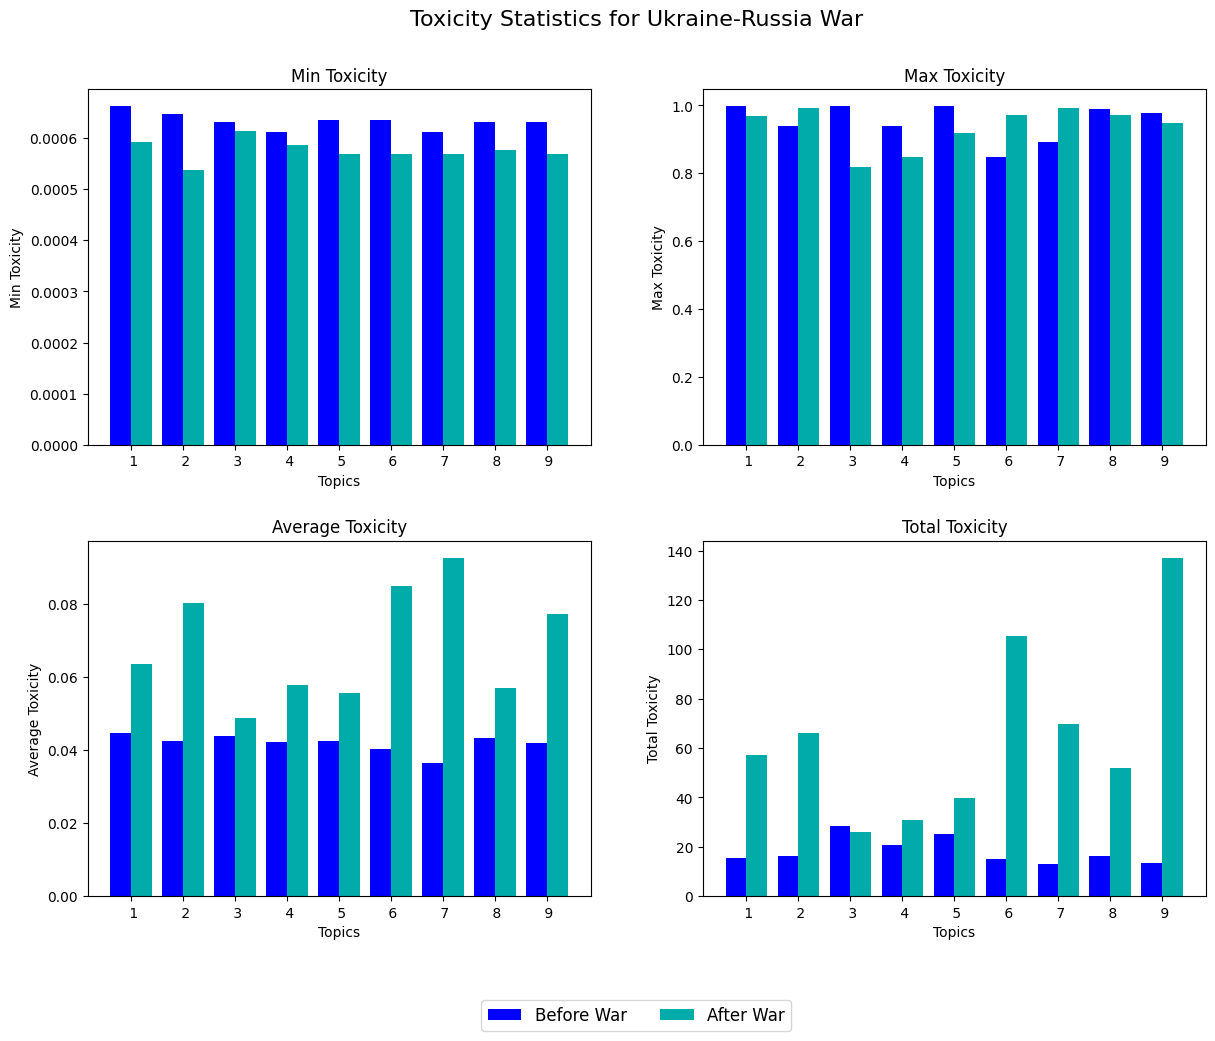

In [72]:
#visualize 
#fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

fig.tight_layout(pad=5.0)
fig.subplots_adjust(top=0.9)

titles = ['Min Toxicity', 'Max Toxicity', 'Average Toxicity', 'Total Toxicity']
metrics = ['min_toxicity', 'max_toxicity', 'average_toxicity', 'total_toxicity']
main_title = 'Toxicity Statistics for Ukraine-Russia War'

offset = 0.1  # Space between bars
cmap = get_cmap('winter')
colors = [cmap(0.0), cmap(0.45), cmap(0.67), cmap(0.80), cmap(1.0)]

fig.suptitle(main_title, fontsize=16)


for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    before_war_values = [before_war_topic_stats[topic][metric] for topic in sorted(before_war_topic_stats.keys())]
    after_war_values = [war_and_after_topic_stats[topic][metric] for topic in sorted(war_and_after_topic_stats.keys())]
    
    topics = range(len(before_war_values))
    width = 0.4
    
    #create bar plots
    bars_before = axs[row, col].bar([x - width/2 for x in topics], before_war_values, width, label='Before War', color = colors[0])
    bars_after = axs[row, col].bar([x + width/2 for x in topics], after_war_values, width, label='After War', color=colors[2])

    #add data labels
    # for bars in [bars_before, bars_after]:
    #     for bar in bars:
    #         yval = bar.get_height()
    #         axs[row, col].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    #titles for subplots
    axs[row, col].set_title(titles[i])
    axs[row, col].set_xlabel('Topics')
    axs[row, col].set_ylabel(metric.title().replace('_', ' '))
    
    axs[row, col].set_xticks(topics)
    new_labels = [f' {i+1}' for i in topics]
    axs[row, col].set_xticklabels(new_labels)
# axs[row, col].legend(loc='upper left', bbox_to_anchor=(1.05, 2))
fig.legend(['Before War', 'After War'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize='large')



# Display the plot
plt.show()

# Linear Regression Model

In [30]:
''''
Function calculates the document-level toxicity score for each document. This is done by taking into account the tf-idf representation of the documents, the dictionary mapping ngrams to toxicity scores, and the names of the features as extracted by the tf-idf vectorizer. 

It uses the pre-existing TF-IDF matrix (before_war_tfidf and war_and_after_tfidf matrix) and the feature names to identify the ngrams in each document and their TF-IDF score. 

Overall it assess the weighted average toxicity of each document by considering both the presence and importance (as indicated by the TF-IDF tmatrix) of toxic ngrams within each document. 
'''
def calculate_doc_level_toxicity(tfidf_matrix, feature_names, ngram_toxicity_dict):

    doc_toxicity_scores = [] #stores avgs for each doc

    #convert tfidf matrix to dense format so we can carry out operations on individual elements. 
    #https://en.ittrip.xyz/python/python-matrix-operations    ngram_present_mat = tfidf_matrix.sign().todense()
    ngram_present_mat = tfidf_matrix.sign().todense()
    
    for doc_idx in range(ngram_present_mat.shape[0]):
        doc_score_list = []  # Will store toxicity scores for the document

        #for each feature
        for feat_idx in range(ngram_present_mat.shape[1]):
            feature = feature_names[feat_idx]
            #checkif ngram is present in doc and has tox_score. If so, append doc_score to list
            if ngram_present_mat[doc_idx, feat_idx] > 0 and feature in ngram_toxicity_dict:
                toxicity_score = ngram_toxicity_dict[feature]
                doc_score_list.append(toxicity_score)

        #calculate the average toxicity score for the document
        if doc_score_list:
            avg_doc_toxicity = np.mean(doc_score_list)
        else:
            # If no ngrams in the document have known toxicity scores
            avg_doc_toxicity = 0

        #store the calculated average toxicity for the document
        doc_toxicity_scores.append(avg_doc_toxicity)

    return np.array(doc_toxicity_scores)

before_war_feature_names = before_war_vect.get_feature_names_out()
before_war_doc_toxicity_scores = calculate_doc_level_toxicity(before_war_tfidf, before_war_feature_names, before_war_ngram_tox_dict)

war_and_after_feature_names = war_and_after_vect.get_feature_names_out()
war_and_after_doc_toxicity_scores = calculate_doc_level_toxicity(war_and_after_tfidf, war_and_after_feature_names, war_and_after_ngram_tox_dict)


In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

x_train = before_war_tfidf
y_train = before_war_doc_toxicity_scores
x_test = war_and_after_tfidf
y_test = war_and_after_doc_toxicity_scores

scaler = RobustScaler(with_centering=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

model = LinearRegression()
model.fit(x_train, y_train)

predicted_tox_scores = model.predict(x_test)

In [87]:

#evalute model performance
mse = mean_squared_error(war_and_after_doc_toxicity_scores, predicted_tox_scores)
mae = mean_absolute_error(war_and_after_doc_toxicity_scores, predicted_tox_scores)
r2 = r2_score(war_and_after_doc_toxicity_scores, predicted_tox_scores)

# print("Best alpha:", model.alpha_)
print(" Mean Squared Error (MSE):", mse)
print(" Mean Absolute Error (MAE):", mae)
print(" R-squared (R2):", r2)


# Create a DataFrame
df_metrics = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R²'],
    'Values': [mse, mae, r2]
})

styled_df = df_metrics.style.background_gradient(cmap='winter')
styled_df

 Mean Squared Error (MSE): 0.012366201187197468
 Mean Absolute Error (MAE): 0.07528548309174041
 R-squared (R2): -0.2410756720278051


,Metric,Values
0,MSE,0.012366
1,MAE,0.075285
2,R²,-0.241076


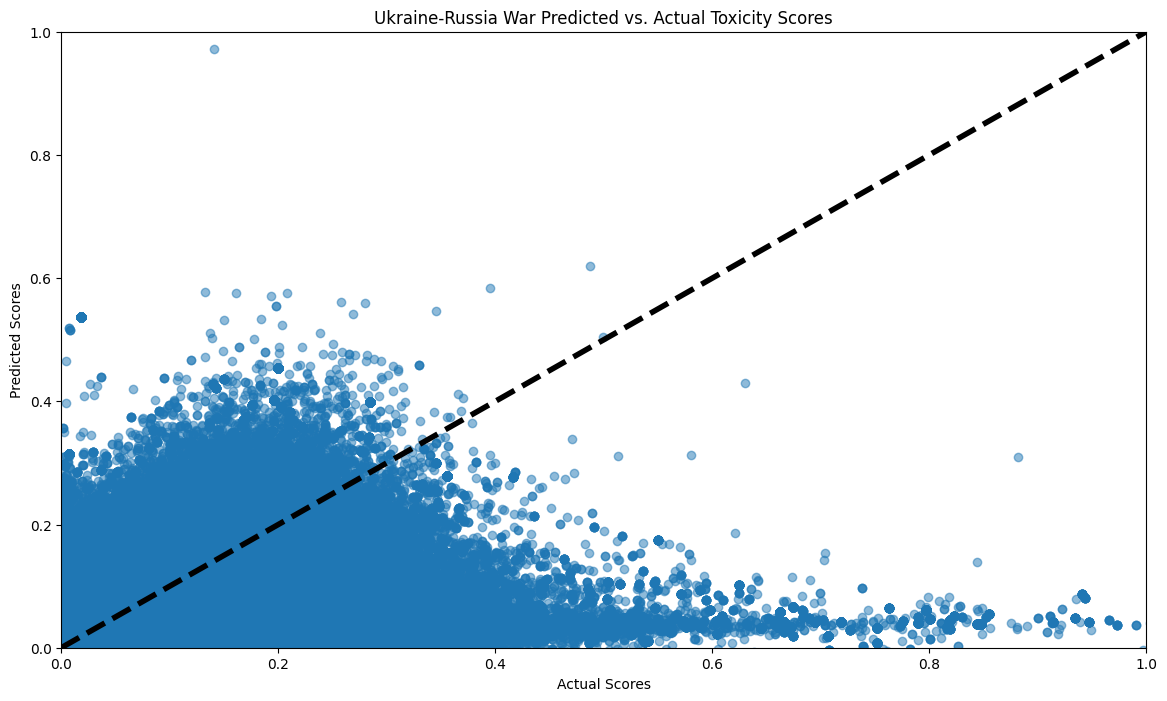

In [88]:
# scatter plot
#scatter plot comparing actual and predicted scores 

#plt.figure(figsize=(10, 8))
plt.figure(figsize=(14, 8))

plt.scatter(y_test, predicted_tox_scores, alpha=0.5)
plt.title('Ukraine-Russia War Predicted vs. Actual Toxicity Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()



# Get Accuracy

In [89]:
# get accuracy
pred_scores = predicted_tox_scores
actual_scores = war_and_after_doc_toxicity_scores
scores_diff = np.abs(actual_scores - pred_scores)



median_thres =  np.median(scores_diff)
print("median as threshold: ", median_thres)
corr_pred = np.sum(scores_diff <= median_thres)
acc_median = corr_pred / len(scores_diff)
print("accuracy for difference: ", acc_median, "\n")

avg_thres =  np.mean(scores_diff)
print("avg as threshold: ", avg_thres)
corr1_pred = np.sum(scores_diff <= avg_thres)
acc_avg = corr1_pred / len(scores_diff)
print("accuracy for difference: ", acc_avg, "\n")

std_thres =  np.std(scores_diff)
print("standard deviation as threshold: ", std_thres)
corr2_pred = np.sum(scores_diff <= std_thres)
acc_std = corr2_pred / len(scores_diff)
print("accuracy for difference: ", acc_std, "\n")

std_avg_thres =  np.std(scores_diff) + np.mean(scores_diff)
print("std_deviation + mean threshold: ", std_avg_thres)
corr3_pred = np.sum(scores_diff <= std_avg_thres)
acc_std_avg = corr3_pred / len(scores_diff)
print("accuracy for difference ", acc_std_avg, "\n")

max_thres =  np.max(scores_diff) * 0.1
print("10% of max as threshold: ", max_thres)
corr4_pred = np.sum(scores_diff <= max_thres)
acc_max = corr4_pred / len(scores_diff)
print("accuracy for difference: ", acc_max, "\n")

quartiles = np.percentile(scores_diff, [25, 50, 75])
first_quartile = quartiles[0]
median = quartiles[1]
third_quartile = quartiles[2]
iqr_thres = third_quartile - first_quartile
print("IQR threshold: ", iqr_thres)
corr_pred5 = np.sum(scores_diff <= iqr_thres)
acc_iqr = corr_pred5 / len(scores_diff)
print("accuracy for difference: ", acc_iqr, "\n")

median as threshold:  0.04747102536863157
accuracy for difference:  0.5357850935152494 

avg as threshold:  0.07528548309174041
accuracy for difference:  0.6944276247521727 

standard deviation as threshold:  0.08184312569080392
accuracy for difference:  0.7140901361709744 

std_deviation + mean threshold:  0.1571286087825443
accuracy for difference  0.884632409320806 

10% of max as threshold:  0.36278364269583124
accuracy for difference:  0.98721981102639 

IQR threshold:  0.06403790797646404
accuracy for difference:  0.6475220494743521 



[(0.04747102536863157, 0.5357850935152494), (0.06403790797646404, 0.6475220494743521), (0.07528548309174041, 0.6944276247521727), (0.08184312569080392, 0.7140901361709744), (0.1571286087825443, 0.884632409320806), (0.36278364269583124, 0.98721981102639)]
thresholds:
(0.04747102536863157, 0.06403790797646404, 0.07528548309174041, 0.08184312569080392, 0.1571286087825443, 0.36278364269583124)





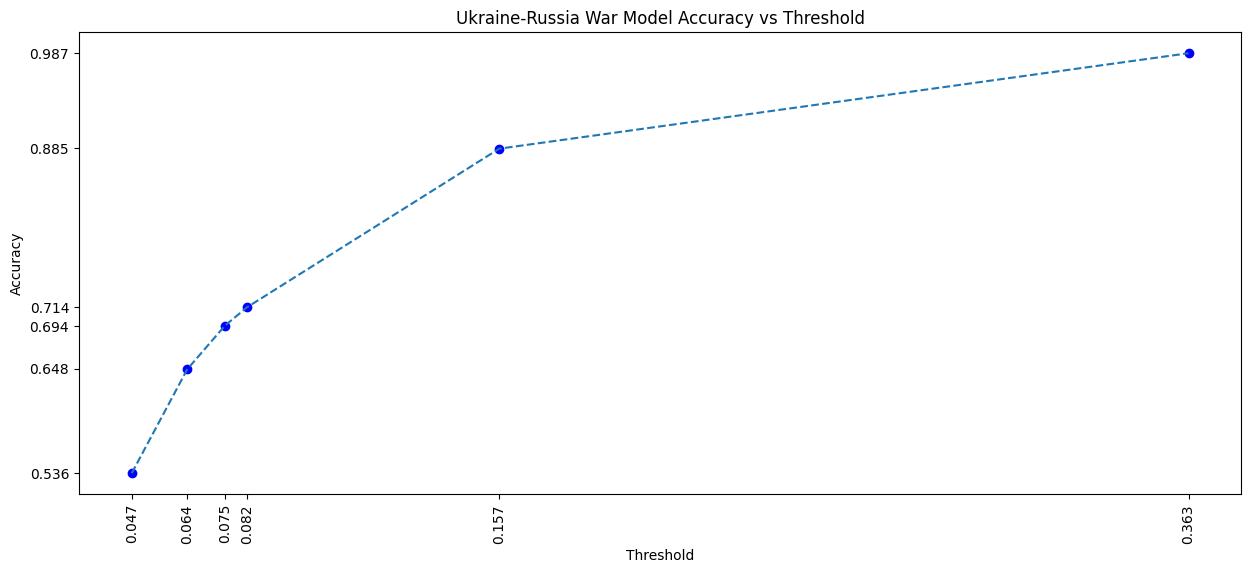

In [97]:
#visualize 
plt.figure(figsize=(15,6))
#sort by accuracy values
thresholds = [median_thres, avg_thres, std_thres, std_avg_thres, max_thres, iqr_thres]
accuracies = [acc_median, acc_avg, acc_std, acc_std_avg, acc_max, acc_iqr]
pairs = list(zip(thresholds, accuracies))
sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=False)
print(sorted_pairs)

sorted_thresholds, sorted_accuracies = zip(*sorted_pairs)
print("thresholds:")
print(sorted_thresholds)
print("\n\n")

plt.scatter(sorted_thresholds, sorted_accuracies, color='blue')
plt.plot(sorted_thresholds, sorted_accuracies,linestyle='--')

plt.title('Ukraine-Russia War Model Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(sorted_thresholds, [f'{t:.3f}' for t in sorted_thresholds])
plt.xticks(rotation=90)  
plt.yticks([round(a, 3) for a in sorted_accuracies])
plt.grid(False)
plt.show()




# Visualize Topic MSE, MAE and R2

In [42]:
#calculate mse, mae, and r2 for each topic

#dictionary to store mse, mae and r2
topic_regression_metrics = {}

#for each topic and its associated documents
for topic_idx, documents in war_and_after_doc_topic_dict.items():
    #extract the actual and predicted scores
    actual_topic_scores = war_and_after_doc_toxicity_scores[documents]
    predicted_topic_scores = predicted_tox_scores[documents]
        
    #calculate the mse, mae and r2
    mse = mean_squared_error(actual_topic_scores, predicted_topic_scores)
    mae = mean_absolute_error(actual_topic_scores, predicted_topic_scores)
    r2 = r2_score(actual_topic_scores, predicted_topic_scores)

    topic_regression_metrics[topic_idx] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    }

topic_regression_metrics = collections.OrderedDict(sorted(topic_regression_metrics.items()))
topic_regression_metrics

OrderedDict([(0,
              {'MSE': 0.030411959261364422,
               'MAE': 0.12235214869325453,
               'R2': -1.2781828159146156}),
             (1,
              {'MSE': 0.022558010410784705,
               'MAE': 0.12247472562165816,
               'R2': -1.7977277583343008}),
             (2,
              {'MSE': 0.013690180596184308,
               'MAE': 0.10614260034582908,
               'R2': -2.834553207616476}),
             (3,
              {'MSE': 0.014523482125279562,
               'MAE': 0.08702991239010625,
               'R2': -0.5361421145595011}),
             (4,
              {'MSE': 0.026625592783923898,
               'MAE': 0.08807693828436268,
               'R2': -4.087859901785092}),
             (5,
              {'MSE': 0.013311741849891496,
               'MAE': 0.08203546639286835,
               'R2': -0.9153059799045553}),
             (6,
              {'MSE': 0.008281098873652765,
               'MAE': 0.06931389325299267,
          

/tmp/ipykernel_386860/1053846138.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


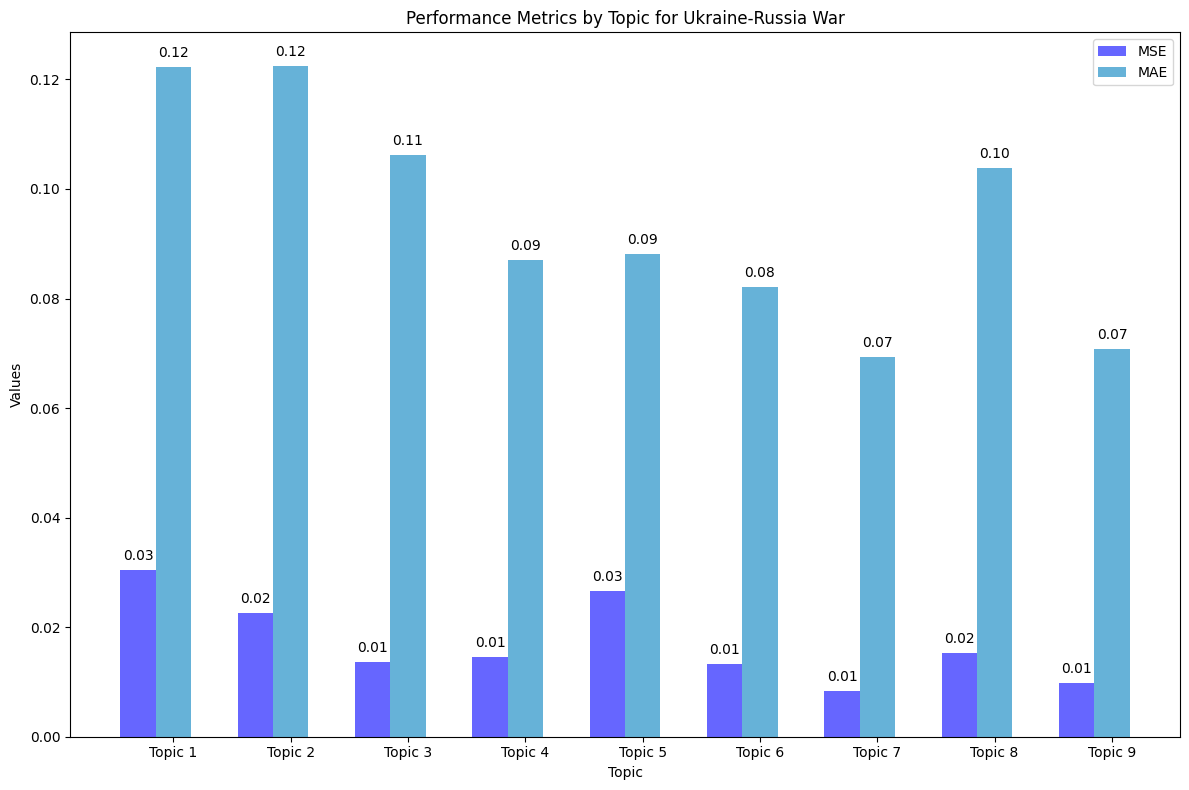

In [71]:
topics = np.arange(1, len(topic_regression_metrics) + 1)  
n_groups = len(topics)
bar_width = 0.3  

index = np.arange(n_groups)
mse_pos = index
mae_pos = index + bar_width
r2_pos = index + 2 * bar_width

mse = [stats['MSE'] for stats in topic_regression_metrics.values()]
mae = [stats['MAE'] for stats in topic_regression_metrics.values()]
# r2 = [stats['R2'] for stats in topic_regression_metrics.values()]

cmap = get_cmap('winter')
colors = cmap(np.linspace(0, 1, 3))

fig, ax = plt.subplots(figsize=(12, 8))
mse_bars = ax.bar(mse_pos, mse, bar_width, label='MSE', alpha=0.6, color=colors[0] )
mae_bars = ax.bar(mae_pos, mae, bar_width, label='MAE', alpha=0.6, color=colors[1])
# r2_bars = ax.bar(r2_pos, r2, bar_width, label='R2', alpha=0.6, color=colors[2])


#data labels
for bars in (mse_bars, mae_bars, r2_bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Topic')
ax.set_ylabel('Values')
ax.set_title('Performance Metrics by Topic for Ukraine-Russia War')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f'Topic {i}' for i in topics])

ax.legend()
plt.tight_layout()
plt.show()


# Get Number of Iterations for LDA

### Before war

Calculating Log-Likelihoods: 100%|████████████| 14/14 [39:42<00:00, 170.18s/it]


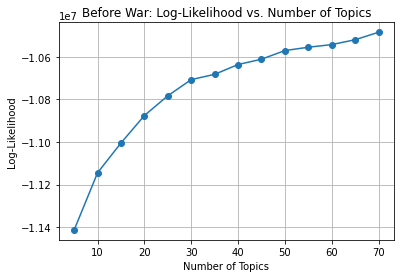

In [6]:
#GET NUM OF TOPICS BEFORE WAR
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 70
step_size = 5
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_topics, max_topics, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()


Calculating Log-Likelihoods: 100%|██████████| 16/16 [6:08:53<00:00, 1383.34s/it]


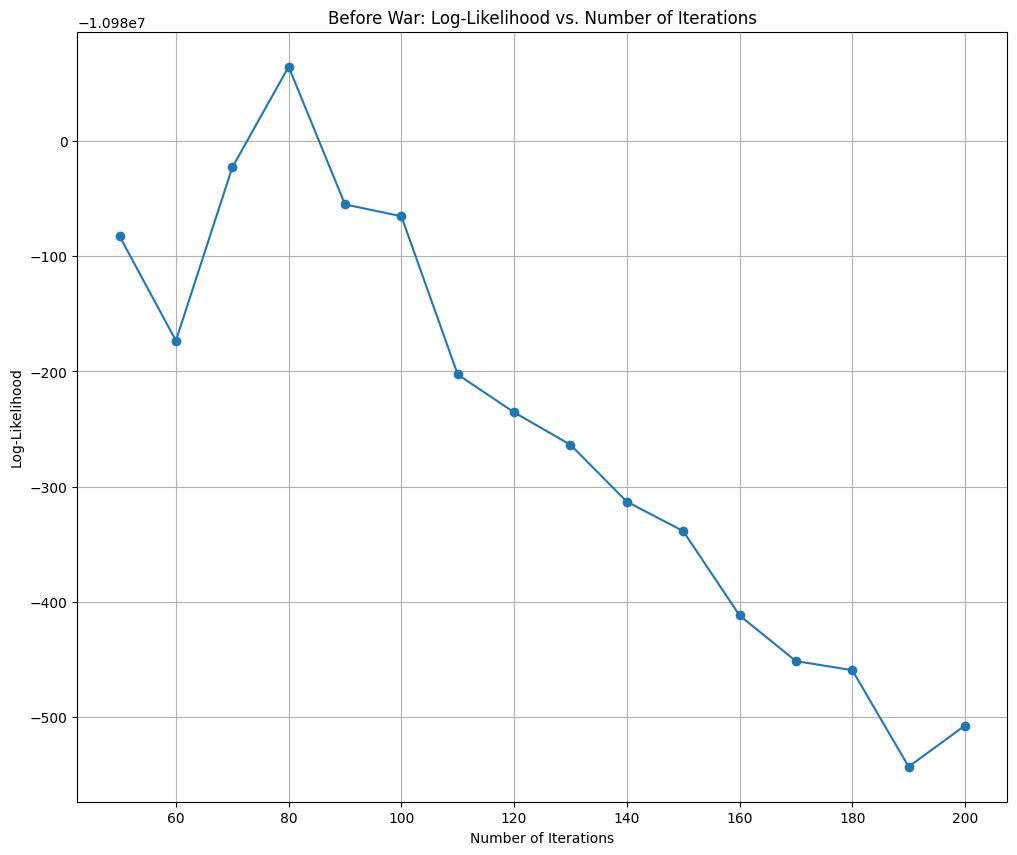

In [9]:
#BEFORE WAR ITERATIONS
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=15, max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 50
max_iter = 200
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_iter, max_iter, step_size)

plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

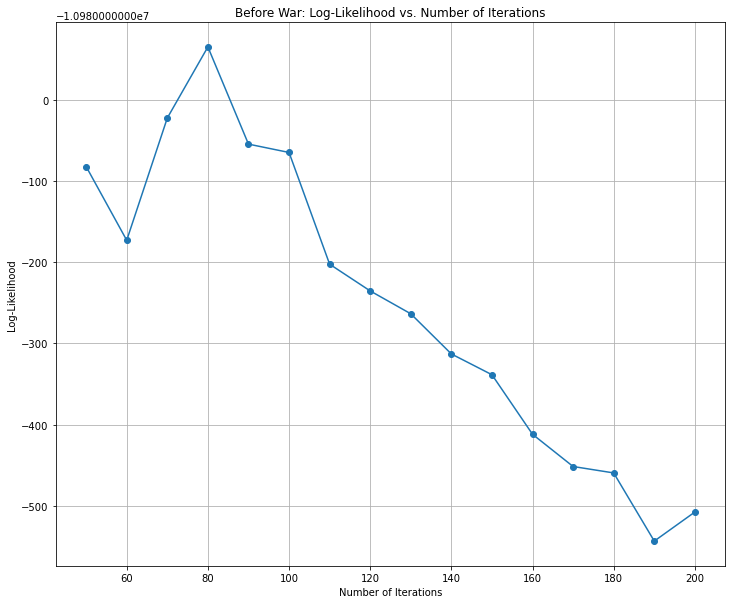

In [9]:
plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

### During and After War

Calculating Log-Likelihoods: 100%|█████████| 11/11 [3:12:46<00:00, 1051.47s/it]


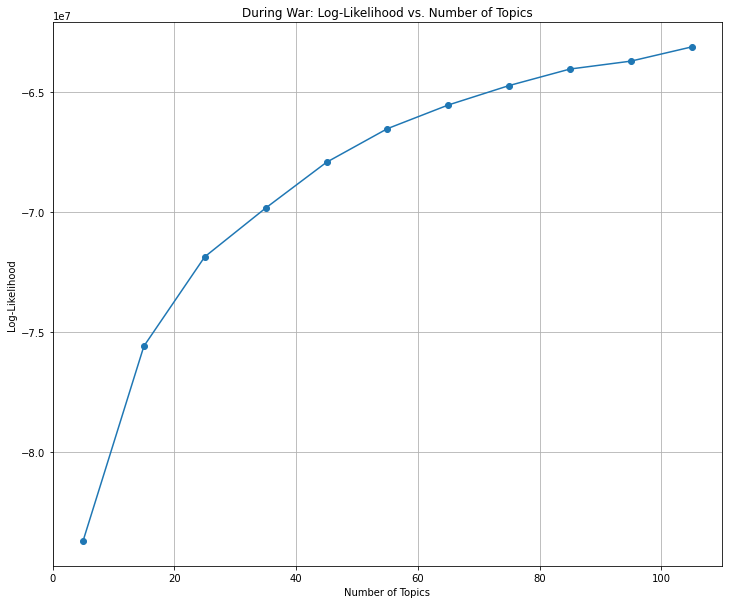

In [8]:
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 100
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_topics, max_topics, step_size)

plt.figure(figsize=(12, 10))  
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

Calculating Log-Likelihoods: 100%|████████████| 3/3 [7:38:14<00:00, 9164.78s/it]


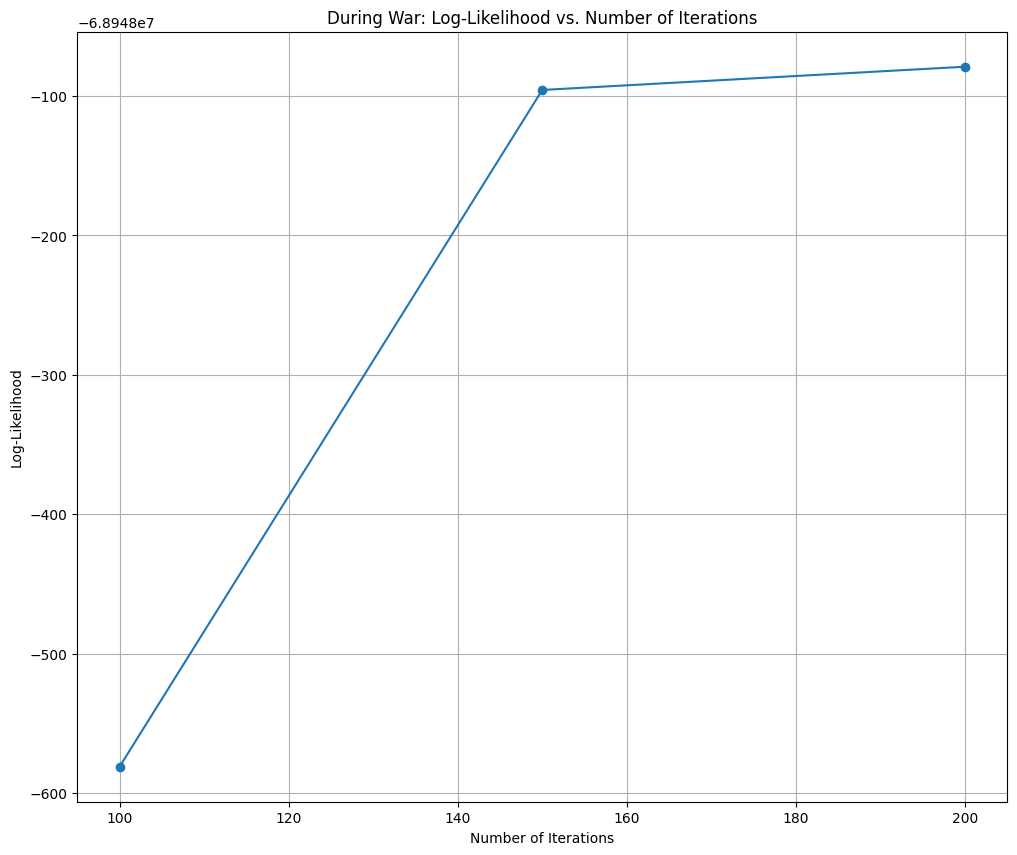

In [8]:
#Number of iterations
#Execution for this code is in Tester.ipynb
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation( max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 100
max_iter = 200
step_size = 50
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_iter, max_iter, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))  
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

In [46]:
n_top_words = 5
tf_feature_names = war_and_after_vect.get_feature_names()
print("After War 10 Clusters: ")
topics = dict()
for topic_idx, topic in enumerate(war_and_after_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [69]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
import random

# Function to generate n-grams
def generate_ngrams(texts):
    n = random.choice([3, 4])  # Choose randomly between 3 and 4
    # Create phrases (trigram or quadgram)
    phrases = Phrases(texts, min_count=1, threshold=n)
    ngram = Phraser(phrases)

    # Apply phrases to texts
    return [ngram[text] for text in texts]

# Sampled datasets
before_war_titles = before_war_sample['cleaned_text'].apply(lambda x: x.split())
war_and_after_titles = war_and_after_sample['cleaned_text'].apply(lambda x: x.split())

# Generate n-grams for sampled datasets
before_war_ngrams = generate_ngrams(before_war_titles)
war_and_after_ngrams = generate_ngrams(war_and_after_titles)

# Create dictionaries for sampled datasets
before_war_dict = Dictionary(before_war_ngrams)
war_and_after_dict = Dictionary(war_and_after_ngrams)

# Filter out tokens based on frequency
before_war_dict.filter_extremes(no_below=10, no_above=0.85)
war_and_after_dict.filter_extremes(no_below=10, no_above=0.85)

# Convert text data to bag-of-words representation (corpora)
before_war_corpora = [before_war_dict.doc2bow(doc) for doc in before_war_ngrams]
war_and_after_corpora = [war_and_after_dict.doc2bow(doc) for doc in war_and_after_ngrams]


# with open('before_war_dict.pkl', 'wb') as f:
#     pickle.dump(before_war_dict, f)
# with open('war_and_after_dict.pkl', 'wb') as f:
#     pickle.dump(war_and_after_dict, f)


# with open('before_war_corpora.pkl', 'wb') as f:
#     pickle.dump(before_war_corpora, f)
# with open('war_and_after_corpora.pkl', 'wb') as f:
#     pickle.dump(war_and_after_corpora, f)

Progress:   0%|                                          | 0/15 [05:17<?, ?it/s]
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
Progress: 100%|███████████████████████████████████| 8/8 [05:07<00:00, 38.41s/it]


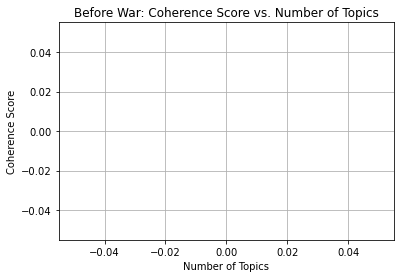

In [72]:
from tqdm import tqdm  # Import tqdm for progress bar
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Define a range of values for the number of topics
min_topics = 5
max_topics = 40
step_size = 5
topic_range = range(min_topics, max_topics + step_size, step_size)

# Initialize lists to store metric scores
coherence_scores = []

# Initialize tqdm progress bar
progress_bar = tqdm(total=len(topic_range), desc='Progress', position=0)

# Iterate over the range of topic values
for num_topics in topic_range:
    # Train LDA model
    before_war_lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=num_topics, random_state=42)
    # Compute coherence score
    coherence_model = CoherenceModel(model=before_war_lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Append coherence score to list
    coherence_scores.append(coherence_score)
    
    # Update progress bar
    progress_bar.update(1)

# Close tqdm progress bar
progress_bar.close()

# Plot the coherence scores
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()


#based on this, it appears that the most ideal number of topics is 10 

In [73]:
# Assuming that corpus is your bag of words corpus and id2word is your dictionary
coherence_scores = []
passes_range = range(50, 200, 10)  # Adjust the range as needed

progress_bar = tqdm(total=len(passes_range), desc='Progress', position=0)
for passes in passes_range:
    print("entering")
    lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=10, passes=passes, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    print("check")
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    progress_bar.update(1)

progress_bar.close()

# You can then plot the coherence scores to see how they change with the number of passes
import matplotlib.pyplot as plt

plt.plot(range(50, 200, 10), coherence_scores)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Iterations')
plt.show()

#80 would be the approximate optimal pass number

Progress:   0%|                                          | 0/15 [00:00<?, ?it/s]

entering


KeyboardInterrupt: 

In [24]:
before_war_lda_model = LdaModel(
    corpus=before_war_corpora,
    id2word=before_war_dict,
    num_topics=10,
    passes=80,
    random_state=42
)

In [25]:
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=before_war_lda_model, corpus=before_war_corpora, dictionary=before_war_dict)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.262562 -0.030267       1        1  27.436326
3      0.278812  0.040294       2        1  20.114719
8      0.258497 -0.030364       3        1  19.479201
7      0.244826  0.017790       4        1  18.278378
1      0.076679  0.110003       5        1   4.305683
5     -0.146633 -0.359194       6        1   3.697824
0     -0.225532  0.044496       7        1   2.206041
4     -0.234310  0.106823       8        1   1.699666
9     -0.252027  0.051907       9        1   1.473531
6     -0.262873  0.048510      10        1   1.308632, topic_info=           Term          Freq         Total Category  logprob  loglift
40          amp   7053.000000   7053.000000  Default  30.0000  30.0000
58         keep  41970.000000  41970.000000  Default  29.0000  29.0000
348      please  10554.000000  10554.000000  Default  28.0000  28.0000
156     mention  10487.000000  10487.000000  Default  27.0000  27.0000
17      ukraine  14938.000000  14938.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
4698     unfair     65.779110     66.629649  Topic10  -4.8723   4.3233
1894          v     64.491509     65.342034  Topic10  -4.8920   4.3231
3617        uag     63.870976     64.721508  Topic10  -4.9017   4.3230
3565         rm     57.709633     58.560172  Topic10  -5.0031   4.3216
3931  stockpile     56.682767     57.533276  Topic10  -5.0211   4.3213

[507 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.160969  aaditharkawat
0         2  0.195011  aaditharkawat
0         3  0.290677  aaditharkawat
0         4  0.343493  aaditharkawat
0         5  0.009836  aaditharkawat
...     ...       ...            ...
1284      5  0.996552             xl
1493      4  0.998036        yeeeees
852       4  0.995619        youtube
2229      5  0.998619           zany
4033      5  0.988906             zn

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 9, 8, 2, 6, 1, 5, 10, 7])

In [100]:

print(pyLDAvis.__version__)

2.1.2


In [16]:
print("Examples of n-grams:")
for i in range(5):  # Print 5 examples
    print(f"Example {i+1}:")
    print("Before War Sample N-grams:", before_war_sample_ngrams[i])
    print("War and After Sample N-grams:", war_and_after_sample_ngrams[i])
    print()

Examples of n-grams:
Example 1:
Before War Sample N-grams: ['aaditharkawat', 'love', 'russia_massing', 'troop_ukraine', 'border', 'ha_already', 'taken', 'piece', 'territory', 'may_invade', 'soon', 'somehow_u', 'fault']
War and After Sample N-grams: []

Example 2:
Before War Sample N-grams: ['aaprpsouthwest', 'sankofabrown', 'u_ha', 'funding', 'right_wing', 'nazi_group', 'since', 'russian_troop', 'amassing', 'near_border', 'similar', 'fashion', 'invaded_crimea', 'ha', 'biden', 'really', 'increased', 'rate', 'ukraine_join', 'nato']
War and After Sample N-grams: []

Example 3:
Before War Sample N-grams: ['aaron_mat', 'amp', 'andrew', 'cockburn', 'ukraine_yemen', 'u_arm', 'industry_reaps', 'spoil_war', 'zerohedge_com', 'geopolitical']
War and After Sample N-grams: []

Example 4:
Before War Sample N-grams: ['aaron', 'schwa', 'melindaharing', 'last', 'pro_russian', 'president', 'lose_power', 'without', 'invasion_occupation', 'maybe', 'putin', 'learn_something', 'american', 'keep_troop', 'bor